<a href="https://colab.research.google.com/github/ascle/colab_tcc2/blob/dev/5_modelagem-classificacao_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Importando bibliotecas<hr style='border: 2px solid red;'>


In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

### Outras configurações<hr style='border: 2px solid red;'>



In [2]:
pd.set_option('display.max_columns', None)

### Conectando no ambiente que será utilizado<hr style='border: 2px solid red;'>


In [3]:
# Importando do Drive
from google.colab import drive
from os import chdir

drive.mount('/content/drive', force_remount=True)
chdir('/content/drive/MyDrive/UFS/tcc-2-ascle-ufs/bases/linkage_marco/')

Mounted at /content/drive


#### Leitura dos dados

In [4]:
data_raw = pd.read_csv('dn_etl.csv', sep=';', low_memory=False)
data_raw.sort_index(axis=1, inplace=True)

In [5]:
data_raw.shape

(192484, 24)

In [6]:
data_raw.head()

,ANO,APGAR1,APGAR5,CODANOMAL_QTD,CONSPRENAT,ESCMAEETL_VALOR,ESTCIVMAE_COMPANHEIRO,GRAVIDEZ_VALOR,LOCNASC_DOMICILIO,LOCNASC_ESTAB_SAUDE,LOCNASC_HOSPITAL,LOCNASC_OUTROS,OBT_NEONATAL,PARTO_CESAREO,PARTO_VAGINALL,PESO,QTDFILMORT,QTDPARTCES,SEMAGESTAC,SEXO_FEM,SEXO_MASC,TPAPRESENT_CEFALICO,TPAPRESENT_PELVICO,TPAPRESENT_TRANSVERSA
0,2015,2.0,4.0,0.0,5.0,1,0,1,0,0,1,0,0,1,0,820.0,1.0,NaN,26.0,0,1,1,0,0
1,2015,9.0,10.0,0.0,8.0,4,1,1,0,0,1,0,0,1,0,4200.0,1.0,NaN,39.0,0,1,1,0,0
2,2015,7.0,8.0,0.0,10.0,11,1,1,0,0,1,0,0,0,1,3700.0,0.0,0.0,40.0,1,0,1,0,0
3,2015,7.0,8.0,0.0,7.0,4,0,1,0,0,1,0,0,0,1,3550.0,1.0,0.0,37.0,0,1,1,0,0
4,2015,9.0,10.0,0.0,3.0,11,0,1,0,0,1,0,0,1,0,3800.0,0.0,NaN,39.0,1,0,1,0,0


## Dados X e y<hr style='border: 2px solid red;'>

In [7]:
X_raw= data_raw.drop(columns=['QTDPARTCES', 'ANO', 'OBT_NEONATAL'])
y_raw= data_raw["OBT_NEONATAL"]

## Dados desbalanceados<hr style='border: 2px solid red;'>

https://medium.com/data-hackers/como-lidar-com-dados-desbalanceados-em-problemas-de-classifica%C3%A7%C3%A3o-17c4d4357ef9

In [8]:
from imblearn.over_sampling import SMOTE

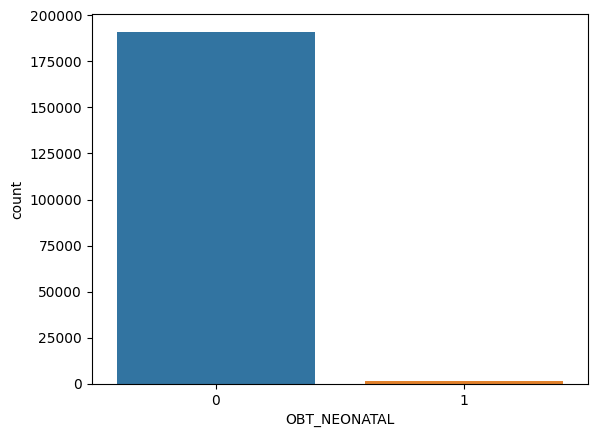

In [9]:
ax = sns.countplot(x='OBT_NEONATAL', data=data_raw)

In [10]:
smt = SMOTE(random_state=123)
X_bal, y_bal = smt.fit_resample(X_raw, y_raw)

In [11]:
data_bal = pd.concat([X_bal, y_bal], axis=1)

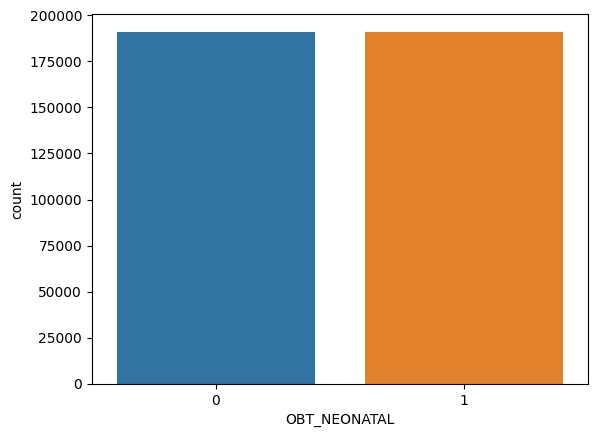

In [12]:
ax = sns.countplot(x='OBT_NEONATAL', data=data_bal)

##Dados de treino e de teste<hr style='border: 2px solid red;'>

In [13]:
from sklearn.model_selection import train_test_split
SEED = 20

In [14]:
X_treino, X_teste, y_treino, y_teste = train_test_split(X_bal, y_bal, test_size =0.25,
                                                        random_state=SEED,
                                                        stratify=y_bal)
print("Treinaremos com %d elementos e testaremos com %d elementos" % (len(X_treino), len(X_teste)))

Treinaremos com 286620 elementos e testaremos com 95540 elementos


Base de treino normalizada

In [15]:
from sklearn.preprocessing import StandardScaler

In [16]:
scaler = scaler = StandardScaler()
scaler.fit(X_treino)
X_treino_norm = scaler.transform(X_treino)
X_teste_norm = scaler.transform(X_teste)

### <font color='red' style='font-size: 30px;'>Dummy Classifier</font>
<hr style='border: 2px solid red;'>

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
modelo_dummy_stratified = DummyClassifier(strategy='stratified')
modelo_dummy_stratified.fit(X_treino, y_treino)
predito_ds = modelo_dummy_stratified.predict(X_teste)

In [19]:
modelo_dummy_mostfrequent = DummyClassifier(strategy="most_frequent")
modelo_dummy_mostfrequent.fit(X_treino, y_treino)
predito_dmf = modelo_dummy_mostfrequent.predict(X_teste)

### <font color='red' style='font-size: 30px;'>Modelo SVC</font>
<hr style='border: 2px solid red;'>

In [20]:
from sklearn.svm import SVC

In [21]:
modelo_svc = SVC(gamma='auto', random_state = SEED)
modelo_svc.fit(X_treino_norm, y_treino)
predito_svc = modelo_svc.predict(X_teste_norm)

### <font color='red' style='font-size: 30px;'>KNN</font>
<hr style='border: 2px solid red;'>

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric

In [22]:
from sklearn.neighbors import KNeighborsClassifier

In [23]:
modelo_knn_euc = KNeighborsClassifier(metric='euclidean')
modelo_knn_euc.fit(X_treino_norm, y_treino)
predito_knn_euc = modelo_knn_euc.predict(X_teste_norm)

In [24]:
modelo_knn_man = KNeighborsClassifier(metric='manhattan')
modelo_knn_man.fit(X_treino_norm, y_treino)
predito_knn_man = modelo_knn_man.predict(X_teste_norm)

In [25]:
modelo_knn_mi = KNeighborsClassifier(metric='minkowski')
modelo_knn_mi.fit(X_treino_norm, y_treino)
predito_knn_mi = modelo_knn_mi.predict(X_teste_norm)

In [26]:
modelo_knn_ch = KNeighborsClassifier(metric='chebyshev')
modelo_knn_ch.fit(X_treino_norm, y_treino)
predito_knn_ch = modelo_knn_ch.predict(X_teste_norm)

### <font color='red' style='font-size: 30px;'>Árvore de decisão</font>
<hr style='border: 2px solid red;'>

In [27]:
from sklearn.tree import DecisionTreeClassifier

In [28]:
modelo_dtc = DecisionTreeClassifier()
modelo_dtc.fit(X_treino, y_treino)
predito_dtc = modelo_dtc.predict(X_teste)

### <font color='red' style='font-size: 30px;'>Random Forest</font>
<hr style='border: 2px solid red;'>

In [29]:
from sklearn.ensemble import RandomForestClassifier

In [30]:
modelo_rfc = RandomForestClassifier(n_estimators = 100)
modelo_rfc.fit(X_treino, y_treino)
predito_rfc = modelo_rfc.predict(X_teste)

## Validando modelos<hr style='border: 2px solid red;'>

### Matriz de Confusão

In [31]:
from sklearn.metrics import confusion_matrix

[Text(0.5, 1.0, 'Mostfrequent')]

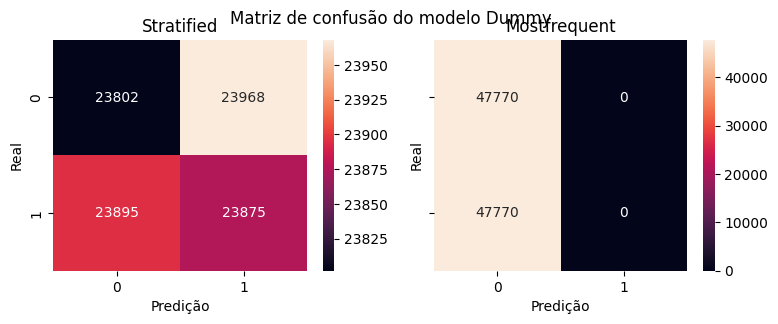

In [32]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3), sharey=True)
fig.suptitle('Matriz de confusão do modelo Dummy')

sns.heatmap(data=confusion_matrix(y_teste, predito_ds), annot = True, fmt = "d", ax=axes[0])
axes[0].set(xlabel = "Predição", ylabel = "Real")
axes[0].set(title='Stratified')

sns.heatmap(confusion_matrix(y_teste, predito_dmf), annot = True, fmt = "d", ax=axes[1])
axes[1].set(xlabel = "Predição", ylabel = "Real")
axes[1].set(title='Mostfrequent')

In [35]:
sns.heatmap(confusion_matrix(y_teste, predito_svc), annot = True, fmt = "d", ax=axes[1]).set(xlabel = "Predição", ylabel = "Real").set(title='SVC')

AttributeError: ignored

In [ ]:
fig, axes = plt.subplots(1, 4, figsize=(20, 4), sharey=True)
fig.suptitle('A matriz de confusão do modelo KNN')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_euc), annot = True, fmt = "d", ax=axes[0])
axes[0].set(xlabel = "Predição", ylabel = "Real")
axes[0].set(title='Euclidiana')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_man), annot = True, fmt = "d", ax=axes[1])
axes[1].set(xlabel = "Predição", ylabel = "Real")
axes[1].set(title='Manhattan')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_mi), annot = True, fmt = "d", ax=axes[2])
axes[2].set(xlabel = "Predição", ylabel = "Real")
axes[2].set(title='Minkowski')

sns.heatmap(data=confusion_matrix(y_teste, predito_knn_ch), annot = True, fmt = "d", ax=axes[3])
axes[3].set(xlabel = "Predição", ylabel = "Real")
axes[3].set(title='Chebyshev')

In [ ]:
ax = sns.heatmap(confusion_matrix(y_teste, predito_dtc), annot = True, fmt = "d")
ax.set(xlabel = "Predição", ylabel = "Real")
ax.set(title='Matriz de confusão do modelo Decision Tree')

### Acurácia

A acurácia é utilizada quando queremos saber a performance geral do modelo, isto é, dentre todas as classificações realizadas, quantas foram classificadas corretamente pelo modelo.

A acurácia é uma boa indicação geral da performance do modelo. Mas, em algumas situações, como em modelos de identificação de fraudes, ela pode ser um pouco enganosa.

A acurácia não é a melhor métrica para ser utilizada em situações que os Falsos Negativos são considerados mais prejudiciais que os Falsos Positivos. Em casos como esse, utilizamos a métrica chamada Recall ou, em português, sensibilidade.

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
print("A acurácia do momelo dummy stratified foi %.2f%%" % (accuracy_score(y_teste, predito_ds) * 100))
print("A acurácia do momelo dummy mostfrequent foi %.2f%%" % (accuracy_score(y_teste, predito_dmf) * 100))

print("A acurácia do modelo SVC foi %.2f%%" % (accuracy_score(y_teste, predito_svc) * 100))

print("A acurácia do modelo KNN Euclidiana foi %.2f%%" % (accuracy_score(y_teste, predito_knn_euc) * 100))
print("A acurácia do modelo KNN Manhattan foi %.2f%%" % (accuracy_score(y_teste, predito_knn_man) * 100))
print("A acurácia do modelo KNN Minkowski foi %.2f%%" % (accuracy_score(y_teste, predito_knn_mi) * 100))
print("A acurácia do modelo KNN Chebyshev foi %.2f%%" % (accuracy_score(y_teste, predito_knn_ch) * 100))

print("A acurácia do modelo Decision Tree foi %.2f%%" % (accuracy_score(y_teste, predito_dtc) * 100))
print("A acurácia do modelo Random Forest foi %.2f%%" % (accuracy_score(y_teste, predito_rfc) * 100))

### Precisão

 A Precisão calcula quantos verdadeiros positivos foram classificados de forma correta, foram preditos de forma correta.

 A precisão é utilizada quando queremos saber dentre todas as classificações de classe Positivo realizadas pelo modelo, quantas estão corretas.

 A precisão pode ser utilizada em situações em que os Falsos Positivos são mais prejudiciais que os Falsos Negativos. Por exemplo, em um modelo de classificação de um bom investimento.

In [ ]:
from sklearn.metrics import precision_score

In [ ]:
print("A Precisão do momelo dummy stratified foi %.2f%%" % (precision_score(y_teste, predito_ds) * 100))
print("A Precisão do momelo dummy mostfrequent foi %.2f%%" % (precision_score(y_teste, predito_dmf) * 100))

print("A Precisão do modelo SVC foi %.2f%%" % (precision_score(y_teste, predito_svc) * 100))

print("A Precisão do modelo KNN Euclidiana foi %.2f%%" % (precision_score(y_teste, predito_knn_euc) * 100))
print("A Precisão do modelo KNN Manhattan foi %.2f%%" % (precision_score(y_teste, predito_knn_man) * 100))
print("A Precisão do modelo KNN Minkowski foi %.2f%%" % (precision_score(y_teste, predito_knn_mi) * 100))
print("A Precisão do modelo KNN Chebyshev foi %.2f%%" % (precision_score(y_teste, predito_knn_ch) * 100))

print("A Precisão do modelo Decision Tree foi %.2f%%" % (precision_score(y_teste, predito_dtc) * 100))
print("A Precisão do modelo Random Forest foi %.2f%%" % (precision_score(y_teste, predito_rfc) * 100))

## Escolhendo o melhor modelo<hr style='border: 2px solid red;'>